In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
print("Modules imported")

Modules imported


The k-means algorithm searches for a **pre-determined** number of clusters within an unlabeled multidimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:

    * The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
    * Each point is closer to its own cluster center than to other cluster centers.


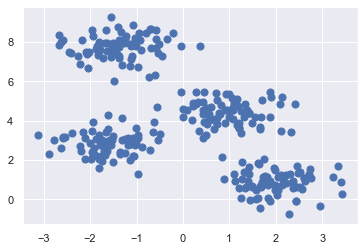

In [2]:
# generate a two-dimensional dataset containing four distinct blobs
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

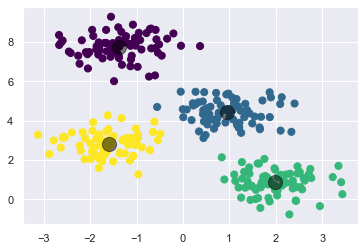

In [4]:
# visualize the results by plotting the data colored by these labels 
# plot the cluster centers as determined by the k-means estimator:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

The k-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.  The typical approach to k-means involves an intuitive iterative approach known as _expectation–maximization_.

Expectation–maximization **(E–M)** is a powerful algorithm that comes up in a variety of contexts within data science. k-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here. In short, the expectation–maximization approach here consists of the following procedure:

    Guess some cluster centers
    
    Repeat until converged
    
        E-Step: assign points to the nearest cluster center
        M-Step: set the cluster centers to the mean
        
        
Here the "E-step" or **"Expectation step"** is so-named because it involves updating our expectation of which cluster each point belongs to. 

The "M-step" or **"Maximization step"** is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

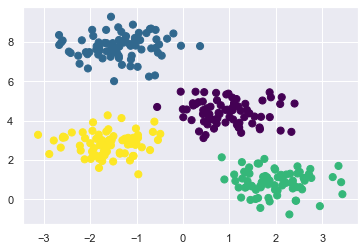

In [5]:
# The k-Means algorithm 
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

## Caveats of expectation–maximization

There are a few issues to be aware of when using the expectation–maximization algorithm.

        The globally optimal result may not be achieved

First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the global best solution. For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

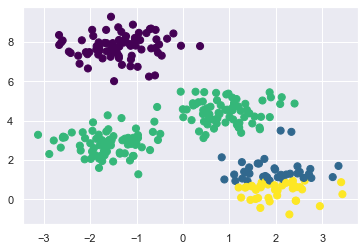

In [6]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the *n_init* parameter, which defaults to 10).

        The number of clusters must be selected beforehand
    
Another common challenge with k-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data. For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

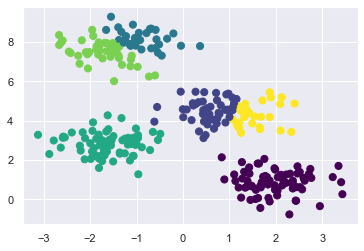

In [7]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

    k-means is limited to linear cluster boundaries

The fundamental model assumptions of k-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between k-means clusters will always be linear, which means that it will fail for more complicated boundaries.

In [8]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

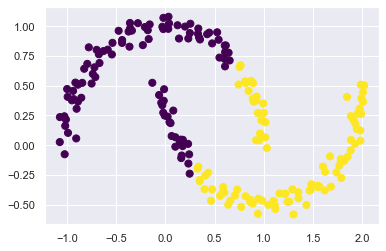

In [9]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

One version of this kernelized k-means is implemented in Scikit-Learn within the SpectralClustering estimator. It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a k-means algorithm:

/Users/alwinsolair/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


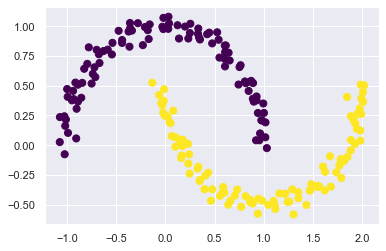

In [10]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

    k-means can be slow for large numbers of samples

Because each iteration of k-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows. You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step. 

### Example 1: k-means on digits

Use k-means to try to identify similar digits without using the original label information; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any a priori label information.

Start by loading the digits and then finding the KMeans clusters. 

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [12]:
# clustering can be performed as before
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

The result is 10 clusters in 64 dimensions. Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster.

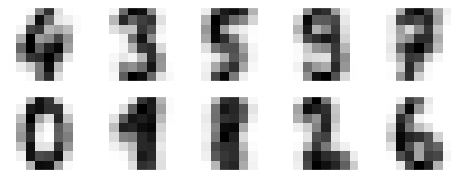

In [13]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We see that even without the labels, KMeans is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

Because k-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted.

In [14]:
# fixed by matching each learned cluster label with the true labels found in them
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [15]:
# check how accurate our unsupervised clustering was in finding similar digits within the data:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

With a simple k-means algorithm, we discovered the correct grouping for 80% of the input digits

# confusion matrix
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

The main point of confusion is between the eights and ones. Using k-means, can essentially build a digit classifier without reference to any known labels!

In [16]:
# use the t-distributed stochastic neighbor embedding (t-SNE) algorithm 
# to pre-process the data before performing k-means. 
# t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters.
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9348914858096828

**93% classification accuracy without using the labels**. 

This is the power of unsupervised learning when used carefully: _it can extract information from the dataset that it might be difficult to do by hand or by eye_.

### Example 2: k-means for colour compression

One interesting application of clustering is in color compression within images.

For example, imagine you have an image with millions of colors. In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

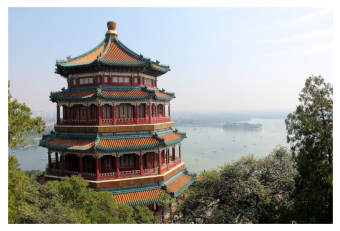

In [17]:
# Scikit-Learn datasets module
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [18]:
china.shape

(427, 640, 3)

In [19]:
# reshape data
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

In [20]:
# subset of 10,000 pixels for efficiency:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

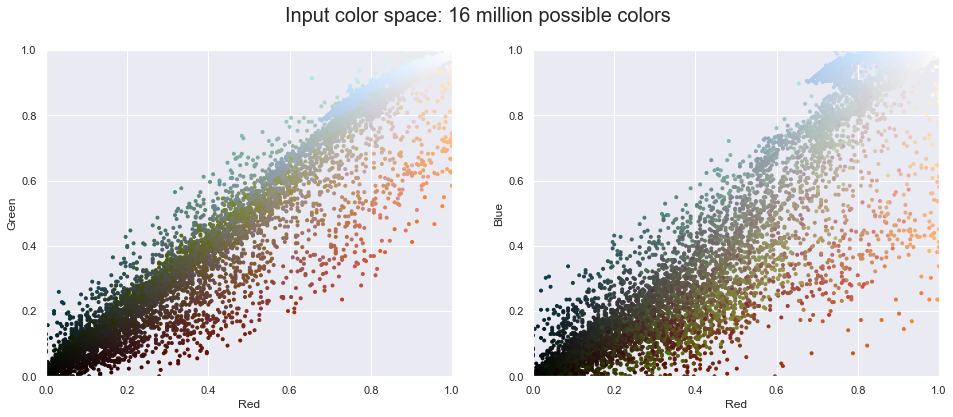

In [21]:
plot_pixels(data, title='Input color space: 16 million possible colors')

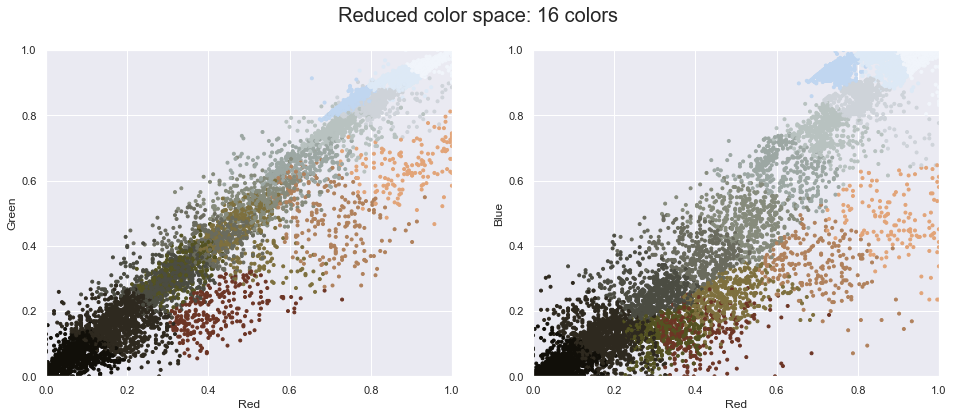

In [23]:
# use the mini batch k-means, which operates on subsets of the data 
# to compute the result much more quickly than the standard k-means algorithm
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

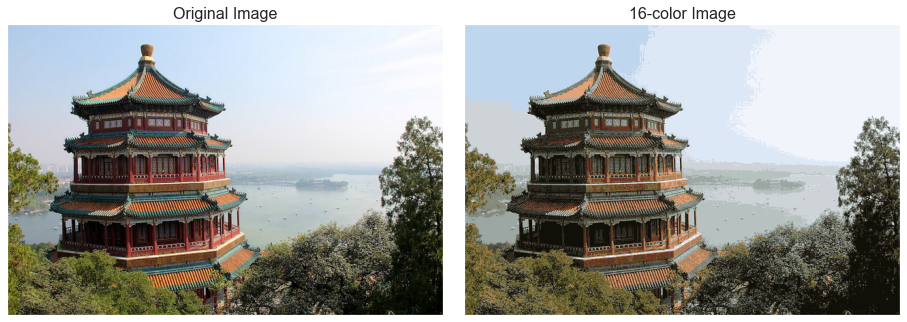

In [24]:
# Plotting these new colors in the image space rather than the pixel space
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable. This image on the right achieves a compression factor of around 1 million! While this is an interesting application of k-means, there are certainly better way to compress information in images. But the example shows the power of thinking outside of the box with unsupervised methods like k-means.